# Notebook to Explore the Proteins and dPFs In Greater Detail

In [1]:
import os
import sys
import feather
import warnings

import numpy as np # Numerical computing
import pandas as pd # Data manipulation

import seaborn as sns # R-like high-level plots
import matplotlib.pyplot as plt # Python's base plotting 
import PyComplexHeatmap as pch # Complex Heatmaps in Python

from multiprocessing import Pool # Multi-threading

sys.path.append('../')
from src import utils, plots

warnings.filterwarnings('ignore')

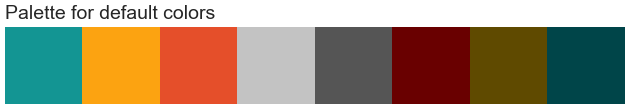

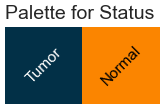

In [2]:
# Create a dictionary for a greyscale color palette with 9 colors
def_colors = [
    "#139593", "#fca311", "#e54f2a",
    "#c3c3c3", "#555555",
    "#690000", "#5f4a00", "#004549"
]

status_colors = {
    "Tumor": "#023047",
    "Normal": "#fb8500",
}
regulation_colors = {
    'Up': "#023047",
    'Down': '#fb8500'
}

# Set seaborn style
sns.set_theme(
    style="white",
    context="paper",
    palette=def_colors,
    font_scale=1,
    rc={
        "figure.figsize": (6, 4),
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
    }
)

# Figure Saving Settings
figure_formats = ["pdf"]
save_to_folder = True
transparet_bg = True
figure_dpi = 300

## Configure dataframe displaying
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

plots.color_palette(
    def_colors, 
    save=False
)

plots.color_palette(
    status_colors,
    name="Status",
    save=False
)

In [3]:
dataTypes = {
    "mean(all)Proteins": "#f4d35e",
    "mean(top)Proteins": "#ee964b",
    "SpectranoutProteins": "#f95738",
    "dPFProteins": "#083d77"
}

test_colors = {
    "Equivalent": "#29335c",
    "UpRegulated": "#bc4749",
    "DownRegulated": "#386641",
    "Unexplained": "#ebd8d0",
    "Excluded": "#565d61"
}
test_markers = {
    "Equivalent": "o",
    "UpRegulated": "^",
    "DownRegulated": "v",
    "Unexplained": "s",
    "Excluded": "x"
}

In [4]:
pThr = 10**-5
notebook_name = "10_DetailedExploration"
data_path = "./data/processed/"
input_path = f"./data/results/"
output_path = f"./data/results/"
figure_path = f"./figures/{notebook_name}/"

# Create the output folder if it does not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Create figure folder structure, if needed
if save_to_folder:
    for i in figure_formats:
        cur_folder = figure_path + i + "/"
        if not os.path.exists(cur_folder):
            os.makedirs(cur_folder)

## Load the data

### Metadata

In [5]:
# Open the feather file
metadata = feather.read_dataframe(f"{data_path}MatchedPatient_TumorNormal_Metadata.feather")
utils.print_shape(metadata, "Metadata")
metadata.head()

Metadata data has 20 rows and 15 columns


,Filename,Date,Samples,Slot,UniqueNames,BCCHR ID,ID,Group,Differentiation,MKI,INPC,NMYC,Location,Location-Note,Info
9,[67] 20240313_GB_NBL-macro-74_Slot1-58_1_399.h...,20240313,NBL-macro-74,Slot1-58,NBL-macro-74_Slot1-58,74.0000,9.0000,Normal,None,None,None,None,AG,None,True
13,[68] 20240313_GB_NBL-macro-75_Slot1-59_1_400.h...,20240313,NBL-macro-75,Slot1-59,NBL-macro-75_Slot1-59,75.0000,13.0000,Normal,None,None,None,None,AG,None,True
15,[69] 20240313_GB_NBL-macro-76_Slot1-60_1_401.h...,20240313,NBL-macro-76,Slot1-60,NBL-macro-76_Slot1-60,76.0000,14.0000,Normal,None,None,None,None,AG,None,True
36,[71] 20240313_GB_NBL-macro-78_Slot1-62_1_403.h...,20240313,NBL-macro-78,Slot1-62,NBL-macro-78_Slot1-62,78.0000,33.0000,Normal,None,None,None,None,AG,None,True
43,[152] 20240322_GB_NBL-macro-80_Slot1-71_1_506....,20240322,NBL-macro-80,Slot1-71,NBL-macro-80_Slot1-71,80.0000,38.0000,Normal,None,None,None,None,AG,None,True


### Uniprot Annotations Data

In [6]:
# UniProt Annotation Data
uniprot_annotation = feather.read_dataframe(f"{data_path}Uniprot_Annotation.feather")
utils.print_shape(uniprot_annotation, "Uniprot Annotation")
uniprot_annotation.head()

Uniprot Annotation data has 370,812 rows and 6 columns


,protein_id,feature,isoform_id,start,end,note
941,A0AV96,CHAIN,,1.0000,593.0000,RNA-binding protein 47
942,A0AV96,DOMAIN,,71.0000,149.0000,RRM 1
943,A0AV96,DOMAIN,,151.0000,233.0000,RRM 2
944,A0AV96,DOMAIN,,246.0000,318.0000,RRM 3
945,A0AV96,REGION,,1.0000,25.0000,Disordered


### Expanded Info Data

In [7]:
expanded_info_data = feather.read_dataframe( f"{input_path}expanded_info_data_updated.feather")
expanded_info_data['isSignificant'] = expanded_info_data['adj.pvalue'] <= pThr
utils.print_shape(expanded_info_data, "Expanded Info Data")
expanded_info_data.head()

Expanded Info Data data has 117,215 rows and 17 columns


,Protein,Peptide,proteinDescription,geneName,startpos,endpos,seqLength,trace,Cov%,isCAP,PeptideID,TumorRegulation,pval,adj.pvalue,isSignificant,ProteoformGroup,cluster_id
0,A0A024RBG1,MKFKPNQTR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,1,10,181,0,23.7569,False,1,Up,0.0034,0.0132,False,0.0000,3
1,A0A024RBG1,TYDREGFK,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,10,18,181,0,23.7569,False,2,Down,0.0000,0.0000,True,1.0000,0
2,A0A024RBG1,SEQEDEVLLVSSSR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,27,41,181,0,23.7569,False,3,Down,0.0124,0.0400,False,0.0000,6
3,A0A024RBG1,LLGIFEQNQDR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,79,90,181,0,23.7569,False,4,Down,0.1599,0.3053,False,1.0000,0
4,A0A024RBG1,LLGIFEQNQDRK,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,79,91,181,1,23.7569,False,5,Down,0.4427,0.6194,False,1.0000,0


### Protein Info

In [8]:
# Create Protein Info 
protein_info = expanded_info_data.groupby("Protein").agg({
    "isCAP": "first",
    "geneName": "first",
    "Cov%": "max",
    "seqLength": "min",
    "Peptide": "count",
    "isSignificant": "sum"
}).reset_index()

withIsoforms = uniprot_annotation.loc[
    uniprot_annotation['feature']=='VAR_SEQ', 'protein_id'
].unique()

protein_info['hasIsoforms'] = protein_info['Protein'].isin(withIsoforms)

protein_info["Significant%"] = protein_info["isSignificant"] / protein_info["Peptide"] * 100
protein_info = protein_info.sort_values("Significant%", ascending=False).reset_index(drop=True)

proteinsWithSignf = protein_info.loc[protein_info['isSignificant'] > 0, "Protein"].to_list()

subset = expanded_info_data.loc[
    expanded_info_data['Protein'].isin(proteinsWithSignf), 
]
pfg_group = subset.groupby(['Protein', 'ProteoformGroup'])
singlePTM_proteins = []
multiPTM_proteins = []
canonical_proteins = []
for grp in pfg_group.groups:
    group_data = pfg_group.get_group(grp)
    # If the group is 0, then it is a single PTM
    if grp[1] == 0:
        canonical_proteins.append(grp[0])
    if grp[1] == -1:
        singlePTM_proteins.append(grp[0])
    if grp[1] > 0:
        multiPTM_proteins.append(grp[0])
print()
print(f"Number of Single-peptide PTM: {len(singlePTM_proteins)}")
print(f"Number of Multi-peptide dPFs: {len(multiPTM_proteins)}")

protein_info['N(canonical)'] = protein_info['Protein'].isin(
    canonical_proteins
).fillna(False).astype(int)
# if the protein has no significant peptides, then N(canonical) = 1
protein_info.loc[protein_info['isSignificant'] == 0, 'N(canonical)'] = 1
protein_info['N(dPFs)'] = protein_info['Protein'].map(
    pd.Series(multiPTM_proteins).value_counts().to_dict()
).fillna(0).astype(int)
protein_info['N(PTM)'] = protein_info['Protein'].map(
    pd.Series(singlePTM_proteins).value_counts().to_dict()
).fillna(0).astype(int)

protein_info.head()


Number of Single-peptide PTM: 1287
Number of Multi-peptide dPFs: 7141


,Protein,isCAP,geneName,Cov%,seqLength,Peptide,isSignificant,hasIsoforms,Significant%,N(canonical),N(dPFs),N(PTM)
0,Q6Y288,False,B3GLCT,16.4659,498,4,2,False,50.0000,0,2,0
1,Q9UMX1,True,SUFU,20.0413,484,4,2,True,50.0000,0,2,0
2,O43156,False,TTI1,8.5399,1089,4,2,False,50.0000,0,1,1
3,Q9NTW7,False,ZFP64,22.7907,645,4,2,True,50.0000,1,1,0
4,Q6P9F7,False,LRRC8B,6.6002,803,4,2,False,50.0000,0,2,0


### Proteoform Info Data

This is same as expanded info data but with using Proteoform ID and don't contain single PTM peptides to only keeping dPFs.

In [9]:
proteoform_info = expanded_info_data[expanded_info_data['ProteoformGroup'] > -1][[
    "Protein", "Peptide", "PeptideID", 
    "proteinDescription", "geneName", 
    "startpos", "endpos", "seqLength", 
    "trace", "Cov%", "isCAP",
    "adj.pvalue", "TumorRegulation", 
    "isSignificant", "ProteoformGroup"
]].rename(columns={"ProteoformGroup": "pfg"})
# Create Proteoform Groups with at least 2 peptides 
prf_grps = proteoform_info.groupby("Protein")["pfg"].value_counts()
proteoform_info["Proteoform"] = proteoform_info['Protein'] + "_" + proteoform_info['pfg'].astype(int).astype(str)

proteoform_info.set_index(["Protein", "Peptide"], inplace=True)
proteoform_info.head()

PeptideID  \
Protein    Peptide                     
A0A024RBG1 MKFKPNQTR               1   
           TYDREGFK                2   
           SEQEDEVLLVSSSR          3   
           LLGIFEQNQDR             4   
           LLGIFEQNQDRK            5   

                                                          proteinDescription  \
Protein    Peptide                                                             
A0A024RBG1 MKFKPNQTR       Diphosphoinositol polyphosphate phosphohydrola...   
           TYDREGFK        Diphosphoinositol polyphosphate phosphohydrola...   
           SEQEDEVLLVSSSR  Diphosphoinositol polyphosphate phosphohydrola...   
           LLGIFEQNQDR     Diphosphoinositol polyphosphate phosphohydrola...   
           LLGIFEQNQDRK    Diphosphoinositol polyphosphate phosphohydrola...   

                          geneName  startpos  endpos  seqLength  trace  \
Protein    Peptide                                                       
A0A024RBG1 MKFKPNQTR        NUDT4B         1      10        181      0   
           TYDREGFK         NUDT4B        10      18        181      0   
           SEQEDEVLLVSSSR   NUDT4B        27      41        181      0   
           LLGIFEQNQDR      NUDT4B        79      90        181      0   
           LLGIFEQNQDRK     NUDT4B        79      91        181      1   

                             Cov%  isCAP  adj.pvalue TumorRegulation  \
Protein    Peptide                                                     
A0A024RBG1 MKFKPNQTR      23.7569  False      0.0132              Up   
           TYDREGFK       23.7569  False      0.0000            Down   
           SEQEDEVLLVSSSR 23.7569  False      0.0400            Down   
           LLGIFEQNQDR    23.7569  False      0.3053            Down   
           LLGIFEQNQDRK   23.7569  False      0.6194            Down   

                           isSignificant    pfg    Proteoform  
Protein    Peptide                                             
A0A024RBG1 MKFKPNQTR               False 0.0000  A0A024RBG1_0  
           TYDREGFK                 True 1.0000  A0A024RBG1_1  
           SEQEDEVLLVSSSR          False 0.0000  A0A024RBG1_0  
           LLGIFEQNQDR             False 1.0000  A0A024RBG1_1  
           LLGIFEQNQDRK            False 1.0000  A0A024RBG1_1

### Test Results Data

In [10]:
results_df = feather.read_dataframe(f"{input_path}results_df_updated.feather")
results_df['isSignificant'] = results_df['adj.pvalue'] <= pThr
utils.print_shape(results_df, "Results Data")
results_df.head()

Results Data data has 2,345,800 rows and 19 columns


,Protein,Peptide,PeptideID,Sample,Condition,Intensity,log10(Intensity),adjIntensity,isReal,isCompMiss,imputeW,TechVarW,Weight,oldCluster,pval,adj.pvalue,TumorRegulation,cluster_id,isSignificant
0,A0A024RBG1,MKFKPNQTR,1,NBL-macro-74_Slot1-58,Normal,212.0579,2.3265,0.0685,False,False,0.0000,0.9965,0.0943,1,0.0034,0.0132,Up,0.0000,False
1,A0A024RBG1,TYDREGFK,2,NBL-macro-74_Slot1-58,Normal,209.3483,2.3209,-0.1467,False,False,0.0000,0.9879,0.0935,0,0.0000,0.0000,Down,1.0000,True
2,A0A024RBG1,SEQEDEVLLVSSSR,3,NBL-macro-74_Slot1-58,Normal,3387.1516,3.5298,0.4020,False,True,0.7500,0.9453,0.7682,2,0.0124,0.0400,Down,0.0000,False
3,A0A024RBG1,LLGIFEQNQDR,4,NBL-macro-74_Slot1-58,Normal,214.4361,2.3313,-0.0740,True,False,1.0000,0.9572,0.9957,0,0.1599,0.3053,Down,1.0000,False
4,A0A024RBG1,LLGIFEQNQDRK,5,NBL-macro-74_Slot1-58,Normal,248.7292,2.3957,0.1671,False,True,0.7500,0.9808,0.7717,0,0.4427,0.6194,Down,1.0000,False


### Centered Protein Data

In [11]:
dataResults = {
    "mean(all)Proteins": feather.read_dataframe(f"{input_path}5_meanAllAnalysis/centered_protein_data.feather"),
    "mean(top)Proteins": feather.read_dataframe(f"{input_path}6_meanTop3Analysis/centered_protein_data.feather"),
    "SpectranoutProteins": feather.read_dataframe(f"{input_path}7_spectranoutAnalysis/centered_protein_data.feather"),
    "dPFProteins": feather.read_dataframe(f"{input_path}8_proteoformAnalysis/centered_protein_data.feather")
}

print("Data Results:")
for k, v in dataResults.items():
    print(f" - {k}: {v.shape}")

Data Results:
 - mean(all)Proteins: (7491, 20)
 - mean(top)Proteins: (7491, 20)
 - SpectranoutProteins: (7484, 18)
 - dPFProteins: (14475, 20)


### QuEStVar Test Results

In [12]:
# Collect the testResults
testResults = {
    "mean(all)Proteins": pd.read_csv(
        f"{input_path}5_meanAllAnalysis/QuEStVar_PairSummary.csv"
    ),
    "mean(top)Proteins": pd.read_csv(
        f"{input_path}6_meanTop3Analysis/QuEStVar_PairSummary.csv"
    ),
    "SpectranoutProteins": pd.read_csv(
        f"{input_path}7_spectranoutAnalysis/QuEStVar_PairSummary.csv"
    ),
    "dPFProteins": pd.read_csv(
        f"{input_path}8_proteoformAnalysis/QuEStVar_PairSummary.csv"
    )
}

print("Test Results:")
for k, v in testResults.items():
    print(f" - {k}: {v.shape}")


Test Results:
 - mean(all)Proteins: (7026, 17)
 - mean(top)Proteins: (6706, 17)
 - SpectranoutProteins: (6726, 17)
 - dPFProteins: (13003, 17)


# Exploring Data

## Single PTM Examples

In [13]:
from importlib import reload
reload(plots)
reload(utils);

### Extract the Annotations for Single PTM Proteins

In [14]:
codes_to_ignore = [
    'CHAIN', 'PEPTIDE', 'PROPEP', 'COILED', 'DOMAIN', 'REGION', 
    'REPEAT', 'HELIX', 'TURN', 'SITE', 'STRUCTURE', 'STRAND', 
    'TOPO_DOM', 'TRANSMEM', 'METAL', 'INTRAMEM'
]
# Get the single peptide PTMs matches
subset = expanded_info_data[expanded_info_data['ProteoformGroup'] == -1]
annot_data = uniprot_annotation.set_index("protein_id")[
    ['feature', 'start', 'end', 'note']
].rename(columns={"start": "startpos", "end": "endpos"})

res = {}
idx = -1
for i in subset.itertuples():
    idx += 1
    cur_protein = i.Protein
    st, en = i.startpos, i.endpos
    try: 
        sub_annot = annot_data.loc[cur_protein]
    except KeyError:
        # If the protein is not in the annotation 
        # set no annotation is available
        res[idx] = pd.DataFrame({
            'Protein': [cur_protein],
            'feature': ['No Annotation'], 
            'startpos': [pd.NA], 
            'endpos': [pd.NA], 
            'note': [pd.NA]
        })
        continue
    
    # Handle Series case
    if isinstance(sub_annot, pd.Series):
        sub_annot = sub_annot.to_frame().T  # Convert Series to DataFrame
    
    # If endpos is NA use startpos 
    sub_annot['endpos'] = sub_annot['endpos'].fillna(sub_annot['startpos'])
    # Extract relevant annotations
    relevant_annotations = sub_annot[
        ((sub_annot['startpos'] >= st) & (sub_annot['startpos'] <= en)) |
        ((sub_annot['endpos'] >= st) & (sub_annot['endpos'] <= en)) |
        ((sub_annot['startpos'] <= st) & (sub_annot['endpos'] >= en))
    ]
    # Remove the annotations that are not relevant
    # e.g. CHAIN, PEPTIDE, PROPEP, COILED, DOMAIN, REGION, REPEAT, HELIX, TURN, SITE, STRUCTURE
    # These are not relevant for PTM
    relevant_annotations = relevant_annotations[~relevant_annotations['feature'].isin(codes_to_ignore)]

    if relevant_annotations.empty:
        res[idx] = pd.DataFrame({
            'Protein': [cur_protein],
            'feature': ['No Annotation'], 
            'startpos': [pd.NA], 
            'endpos': [pd.NA], 
            'note': [pd.NA]
        })
        continue
    else:
        relevant_annotations['Protein'] = cur_protein
    res[idx] = relevant_annotations

# Concatenate all results into a single DataFrame
final_res = pd.concat(res.values(), keys=res.keys(), names=['protein_id']).reset_index(drop=True)
final_res['note'] = final_res['note'].fillna("")
final_res

,feature,startpos,endpos,note,Protein
0,DISULFID,43.0000,113.0000,,A0A075B6S2
1,DISULFID,41.0000,117.0000,,A0A0B4J1V6
2,VAR_SEQ,1.0000,593.0000,Missing (in isoform 5),A0FGR8
3,No Annotation,NaN,NaN,,A1L0T0
4,No Annotation,NaN,NaN,,A2RU67
...,...,...,...,...,...
2022,No Annotation,NaN,NaN,,Q9Y6I9
2023,No Annotation,NaN,NaN,,Q9Y6J0
2024,No Annotation,NaN,NaN,,Q9Y6M9
2025,No Annotation,NaN,NaN,,Q9Y6N8


### Get the Proteins with Single PTM and with Annotations Matched

#### Looking Specifically for Pediatric Cancer Associated Proteins

In [15]:
singlePTMs_with_annotations = final_res.loc[final_res['feature'] != 'No Annotation', 'Protein'].unique()
singlePTM_focus = protein_info[protein_info['Protein'].isin(singlePTMs_with_annotations)].copy()
# Subset for only single PTMs
singlePTM_focus = singlePTM_focus[
    (singlePTM_focus['N(dPFs)'] == 0 ) &
    (singlePTM_focus['N(PTM)'] > 0) & 
    (singlePTM_focus['isCAP'] == 1)
].sort_values("seqLength", ascending=True)
print(f"The number of proteins with single PTMs (and UniProt Annotation Match) and no dPFs: {singlePTM_focus.shape[0]}")
utils.view_table(
    singlePTM_focus, 
    page_size=10, 
    page_number=1
)

The number of proteins with single PTMs (and UniProt Annotation Match) and no dPFs: 14
Total pages: 2, Current page: 1


,Protein,isCAP,geneName,Cov%,seqLength,Peptide,isSignificant,hasIsoforms,Significant%,N(canonical),N(dPFs),N(PTM)
1974,O15392,True,BIRC5,50.0000,142,6,1,True,16.6667,1,0,1
2169,P07992,True,ERCC1,26.5993,297,6,1,True,16.6667,1,0,1
1263,P49918,True,CDKN1C,32.5949,316,5,1,True,20.0000,1,0,1
1376,Q96GD4,True,AURKB,60.4651,344,10,2,True,20.0000,1,0,1
105,O75462,True,CRLF1,25.5924,422,5,2,False,40.0000,1,0,1
1333,Q01196,True,RUNX1,25.1656,453,5,1,True,20.0000,1,0,1
3434,P53350,True,PLK1,25.8706,603,8,1,False,12.5000,1,0,1
2055,Q15910,True,EZH2,26.4075,746,6,1,True,16.6667,1,0,1
1187,P15056,True,BRAF,11.3577,766,5,1,False,20.0000,1,0,1
527,P11362,True,FGFR1,12.2871,822,4,1,True,25.0000,1,0,1


##### Candidates:

- **RUNX1** (Q01196):
    - This has a miss in the last peptide in tumor samples while the most normal peptides have no or minimal intensity in previous peptides. Phosphosite at 256 which could be the reasons, there are also many isoforms of this protein. This is not a very confident case but could stil be interesting to explore.
- **PLK1** (P53350):
    - Phosphothreonine; by AURKA () There are also mutagens with various activities, even though it is hard to say which is the case that I am seeing all are very interesting possibilities. This is a very interesting case to explore.
- **KIT** (P10721):
    - At the significant peptide where the peptide in tumor samples is missing and normal is there. There is a disulfide bond from 428-491. This could be interesting, although I want a more confident case.



Current Protein: P53350


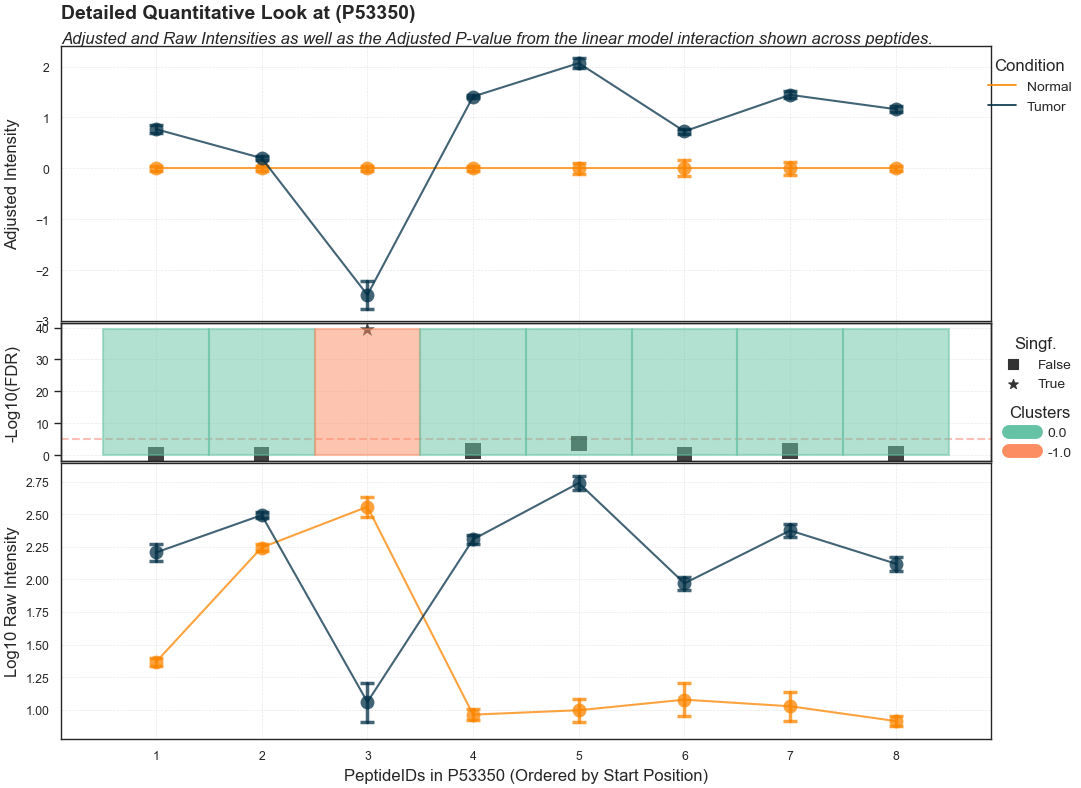

In [16]:
current_protein = 'P53350'
to_save = True

print(f'Current Protein: {current_protein}')

## Detailed Peptide with Clusters
_ = plots.detailed_peptide_with_clusters(
    data=results_df,
    cur_protein=current_protein,
    pThr=pThr,
    condition_palette=status_colors,
    save=to_save,
    filename=f"PeptideIntensity_withClusters_{current_protein}",
    filepath=figure_path,
    fileformats=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

In [17]:
utils.view_table(
    expanded_info_data.loc[
        expanded_info_data["Protein"] == current_protein
    ],
    page_number=1
)

Total pages: 1, Current page: 1


,Protein,Peptide,proteinDescription,geneName,startpos,endpos,seqLength,trace,Cov%,isCAP,PeptideID,TumorRegulation,pval,adj.pvalue,isSignificant,ProteoformGroup,cluster_id
42956,P53350,AGVPGVAAPGAPAAAPPAK,erine/threonine-protein kinase PLK1,PLK1,19,38,603,1,25.8706,True,1,Up,0.7622,0.8624,False,0.0000,0
42957,P53350,SLLLKPHQR,erine/threonine-protein kinase PLK1,PLK1,86,95,603,0,25.8706,True,2,Up,0.6074,0.7548,False,0.0000,4
42958,P53350,KTLCGTPNYIAPEVLSK,erine/threonine-protein kinase PLK1,PLK1,208,225,603,0,25.8706,True,3,Down,0.0000,0.0000,True,-1.0000,9
42959,P53350,TLCGTPNYIAPEVLSK,erine/threonine-protein kinase PLK1,PLK1,209,225,603,1,25.8706,True,4,Up,0.0190,0.0572,False,0.0000,8
42960,P53350,FSIAPSSLDPSNR,erine/threonine-protein kinase PLK1,PLK1,324,337,603,0,25.8706,True,5,Up,0.0000,0.0002,False,0.0000,7
42961,P53350,FSIAPSSLDPSNRKPLTVLNK,erine/threonine-protein kinase PLK1,PLK1,324,345,603,1,25.8706,True,6,Up,0.5721,0.7278,False,0.0000,0
42962,P53350,EKEEPVVR,erine/threonine-protein kinase PLK1,PLK1,356,364,603,0,25.8706,True,7,Up,0.0157,0.0487,False,0.0000,7
42963,P53350,LSLLEEYGCCK,erine/threonine-protein kinase PLK1,PLK1,563,574,603,0,25.8706,True,8,Up,0.2050,0.3651,False,0.0000,8


In [18]:
final_res
utils.view_table(
    final_res.loc[
        final_res["Protein"] == current_protein
    ],
    page_number=1
)

Total pages: 1, Current page: 1


,feature,startpos,endpos,note,Protein
641,MOD_RES,210.0000,210.0000,Phosphothreonine; by AURKA,P53350
642,MOD_RES,214.0000,214.0000,Phosphothreonine,P53350
643,MUTAGEN,210.0000,210.0000,T->A: Abolishes activity. Abolishes checkpoint...,P53350
644,MUTAGEN,210.0000,210.0000,T->D: Increases activity and restores recovery...,P53350
645,MUTAGEN,210.0000,210.0000,"T->V: Reduced catalytic activity, but no effec...",P53350


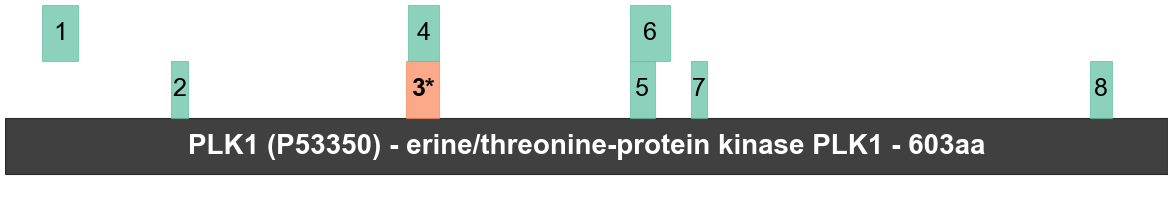

In [19]:
subset = expanded_info_data.loc[
    expanded_info_data["Protein"] == current_protein
] # Contains the peptides (startpos, endpos, trace(for place ontop)) protein seqLength
# Make dictionary for the peptide colors
cur_palette = dict(
    zip(
        subset['ProteoformGroup'].astype(int).unique(), 
        sns.color_palette("Set2", n_colors=subset['ProteoformGroup'].nunique()).as_hex()
    )
)
# Ensure -1 is included in the palette
if -1 not in cur_palette:
    cur_palette[-1] = sns.color_palette("Set2", n_colors=1).as_hex()[0]

cur_seqLength = subset['seqLength'].max()
cur_protein = subset['Protein'].unique()[0]
cur_description = subset['proteinDescription'].unique()[0]
cur_geneName = subset['geneName'].unique()[0]
cur_proteoformGroup = subset['ProteoformGroup'].unique()
protein_string = f"{cur_geneName} ({cur_protein}) - {cur_description} - {cur_seqLength}aa"

# Calculate the maximum number of traces to adjust the figure height
max_traces = subset['trace'].max()
fig_height = 2 + max_traces * 0.5

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, fig_height))
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.6 + max_traces * 0.25)

# First y item is the protein rectangle
ax.add_patch(plt.Rectangle((0, 0.1), 1, 0.25, color="black", alpha=0.75))
# Add the protein string centered horizontally and vertically
ax.text(0.5, 0.225, protein_string, ha='center', va='center', fontsize=20, fontweight='bold', color='white')

# Add the peptide rectangles
for i in subset.itertuples():
    st, en = i.startpos / i.seqLength, i.endpos / i.seqLength
    pid = i.PeptideID
    ptr = i.trace
    psg = i.isSignificant
    grp = i.ProteoformGroup
    if psg:
        pid = f"{pid}*"
        pfw = "bold"
    else:
        pfw = "normal"
    
    # Use traces to build rectangles on top if the peptides overlap
    if ptr > 0:
        ax.add_patch(plt.Rectangle((st, 0.35 + 0.25 * ptr), en - st, 0.25, color=cur_palette[grp], alpha=0.75))
    else:
        ax.add_patch(plt.Rectangle((st, 0.35), en - st, 0.25, color=cur_palette[grp], alpha=0.75))
        
    ax.text(st + 0.5 * (en - st), 0.475 + 0.25 * ptr, pid, ha='center', va='center', fontsize=18, fontweight=pfw, color='black')

# Remove the axis
ax.axis('off')
if to_save:
    # Save the figure
    plots.save_figures(
        plt.gcf(),
        filename=f"PeptidesOnProtein_{current_protein}",
        filepath=figure_path,
        fileformat=figure_formats,
        dpi=figure_dpi,
        transparent=transparet_bg
    )

In [20]:
utils.view_table(
    uniprot_annotation.loc[
        uniprot_annotation['protein_id'] == current_protein
    ].sort_values(["start", "end"]),
    # page_size=10,
    page_number=1
)

Total pages: 6, Current page: 1


,protein_id,feature,isoform_id,start,end,note
240244,P53350,REGION,,1.0000,35.0000,Disordered
240239,P53350,INIT_MET,,1.0000,NaN,Removed
240240,P53350,CHAIN,,2.0000,603.0000,Serine/threonine-protein kinase PLK1
240257,P53350,MOD_RES,,2.0000,NaN,N-acetylserine
240299,P53350,CONFLICT,,2.0000,NaN,S -> T (in Ref. 1; AAA56634)
240258,P53350,MOD_RES,,6.0000,NaN,Phosphothreonine
240300,P53350,CONFLICT,,11.0000,NaN,A -> P (in Ref. 1; AAA56634)
240271,P53350,VARIANT,,12.0000,NaN,R -> L (in a lung squamous cell carcinoma samp...
240268,P53350,CROSSLNK,,19.0000,NaN,Glycyl lysine isopeptide (Lys-Gly) (interchain...
240310,P53350,STRAND,,42.0000,46.0000,


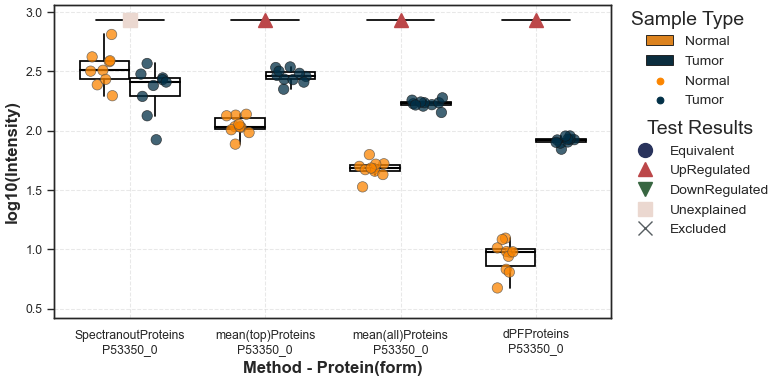

In [21]:
# Create UniqueNames:Group dictionary
sample_group = metadata.set_index("UniqueNames")['Group'].to_dict()
# Initialize the plot data
plot_data = pd.DataFrame()
# Loop through the centered data and create a plot data
for k, v in dataResults.items():
    if k != 'dPFProteins':
        tmp = v.loc[current_protein].to_frame().reset_index().rename(columns={current_protein: "Intensity"})
        tmp['Method'] = k
        tmp['Status'] = tmp['UniqueNames'].map(sample_group)
        tmp['Protein'] = current_protein + "_0"
        plot_data = pd.concat([plot_data, tmp], axis=0, ignore_index=True)
    else:
        uniq_pfgs = proteoform_info.loc[current_protein, 'Proteoform'].unique()
        for pfg in uniq_pfgs:
            tmp = v.loc[pfg].to_frame().reset_index().rename(columns={pfg: "Intensity", 'Sample': 'UniqueNames'})
            tmp['Method'] = k
            tmp['Status'] = tmp['UniqueNames'].map(sample_group)
            tmp['Protein'] = pfg
            plot_data = pd.concat([plot_data, tmp], axis=0, ignore_index=True)

plot_data['ID'] = plot_data['Method'] + "\n" + plot_data['Protein']
plot_data['log10(Intensity)'] = np.log10(plot_data['Intensity'])    

test_data = pd.DataFrame()
# Extract the test results for the current protein and pas
for k, v in testResults.items():
    if k != 'dPFProteins':
        try: 
            tmp = v.loc[
                v['Protein'] == current_protein, ['log2FC', 'log10(adj_pval)', 'Status']
            ].to_dict(orient='records')[0]
        except IndexError:
            tmp = {
                'log2FC': 0, 'log10(adj_pval)': 0, 'Status': 'Excluded'
            }
        # Update Status if Different to UpRegulated or DownRegulated
        if tmp['Status'] == 'Different':
            if tmp['log2FC'] > 0:
                tmp['Status'] = 'UpRegulated'
            else:
                tmp['Status'] = 'DownRegulated'

        tmp['Method'] = k
        tmp['Protein'] = current_protein + "_0"
        test_data = pd.concat([test_data, pd.DataFrame([tmp])], axis=0, ignore_index=True)

    else:
        for j in proteoform_info.loc[current_protein, 'Proteoform'].unique():
            try:
                tmp = v.loc[
                    v['Proteoform'] == j, ['log2FC', 'log10(adj_pval)', 'Status']
                ].to_dict(orient='records')[0]
            except IndexError:
                tmp = {
                    'log2FC': 0, 'log10(adj_pval)': 0, 'Status': 'Excluded'
                }
            # Update Status if Different to UpRegulated or DownRegulated
            if tmp['Status'] == 'Different':
                if tmp['log2FC'] > 0:
                    tmp['Status'] = 'UpRegulated'
                else:
                    tmp['Status'] = 'DownRegulated'

            tmp['Method'] = k
            tmp['Protein'] = current_protein + "_0"
            test_data = pd.concat([test_data, pd.DataFrame([tmp])], axis=0, ignore_index=True)

test_data['ID'] = test_data['Method'] + "\n" + test_data['Protein']
test_data
        

# Ensure the order is [SpectranoutProteins, mean(top)Proteins, mean(all)Proteins, dPFProteins-and-isoforms]
plot_data['Method'] = pd.Categorical(
    plot_data['Method'], 
    categories=['SpectranoutProteins', 'mean(top)Proteins', 'mean(all)Proteins', 'dPFProteins'],
    ordered=True
)
test_data['Method'] = pd.Categorical(
    test_data['Method'], 
    categories=['SpectranoutProteins', 'mean(top)Proteins', 'mean(all)Proteins', 'dPFProteins'],
    ordered=True
)

plot_data = plot_data.sort_values(["Method", 'ID'])
test_data = test_data.sort_values(["Method", 'ID'])

yOffset = 0.25
ymin = plot_data['log10(Intensity)'].min() - yOffset
ymax = plot_data['log10(Intensity)'].max() + yOffset

fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(
    ax=ax, data=plot_data,
    x='ID', y='log10(Intensity)', 
    hue='Status', palette=status_colors,
    width=.75, fliersize=0, linewidth=1.25,
    whiskerprops=dict(color="black"),
    capprops={"color": "black", "linewidth": 0},
    medianprops={"color": "black", "linewidth": 1.5},
    boxprops=dict(facecolor="none", edgecolor="black"),
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"},
)
stripplot = sns.stripplot(
    ax=ax, data=plot_data,
    x='ID', y='log10(Intensity)', 
    hue='Status', palette=status_colors, 
    dodge=True, linewidth=0.5,
    jitter=0.25, s=7.5, alpha=0.75,
    rasterized=True
)

# Adds annotation for the test results
for i, cur_data in test_data.iterrows():
    if cur_data['ID'] in plot_data['ID'].unique().tolist():
        x = plot_data['ID'].unique().tolist().index(cur_data['ID'])
        y = plot_data['log10(Intensity)'].max() + (yOffset * 0.5)
        # Draw lines to indicate the groups being compared
        ax.plot([x-0.25, x+0.25], [y, y], color="black", linewidth=1.25)
        # Annotate the p-value with a marker
        ax.plot(x, y, marker=test_markers[cur_data['Status']], color=test_colors[cur_data['Status']], markersize=10)

ax.set_ylim(ymin, ymax)
ax.set_ylabel("log10(Intensity)", fontsize=12, fontweight="bold")
ax.set_xlabel("Method - Protein(form)", fontsize=12, fontweight="bold")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
ax.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0., fontsize=10, frameon=False, title="Sample Type" ,title_fontsize=14, )
# Add another legend for the Test Results
ax2 = ax.twinx()
ax2.set_yticks([])
ax2.legend(
    handles=[
        plt.Line2D([0], [0], marker=test_markers[i], color=test_colors[i], markersize=10, linestyle="None", label=i)
        for i in test_colors.keys()
    ],
    title="Test Results",title_fontsize=14, 
    loc=2, fontsize=10, frameon=False,
    bbox_to_anchor=(1.025, .65), borderaxespad=0.
)

plt.tight_layout()

if to_save:
    # Save the figure
    plots.save_figures(
        plt.gcf(),
        filename=f"ProteinIntensity_Comparison_{current_protein}",
        filepath=figure_path,
        fileformat=figure_formats,
        dpi=figure_dpi,
        transparent=transparet_bg
    )

#### Non-Pediatric Cancer Associated Proteins with Single PTM

In [22]:
singlePTMs_with_annotations = final_res.loc[final_res['feature'] != 'No Annotation', 'Protein'].unique()
singlePTM_focus = protein_info[protein_info['Protein'].isin(singlePTMs_with_annotations)].copy()
# Subset for only single PTMs
singlePTM_focus = singlePTM_focus[
    (singlePTM_focus['N(dPFs)'] == 0 ) &
    (singlePTM_focus['N(PTM)'] > 0) & 
    (singlePTM_focus['isCAP'] == 0)
].sort_values("seqLength", ascending=True)
print(f"The number of proteins with single PTMs (and UniProt Annotation Match) and no dPFs: {singlePTM_focus.shape[0]}")
utils.view_table(
    singlePTM_focus, 
    page_size=10, 
    page_number=3
)

The number of proteins with single PTMs (and UniProt Annotation Match) and no dPFs: 508
Total pages: 51, Current page: 3


,Protein,isCAP,geneName,Cov%,seqLength,Peptide,isSignificant,hasIsoforms,Significant%,N(canonical),N(dPFs),N(PTM)
3957,P29762,False,CRABP1,80.2920,137,9,1,False,11.1111,1,0,1
2295,O94772,False,LY6H,41.4286,140,6,1,True,16.6667,1,0,1
4125,P41223,False,BUD31,84.0278,144,9,1,True,11.1111,1,0,1
3044,P55008,False,AIF1,51.7007,147,7,1,True,14.2857,1,0,1
1964,P03950,False,ANG,36.7347,147,6,1,False,16.6667,1,0,1
4797,Q9BVJ7,False,DUSP23,95.3333,150,11,1,False,9.0909,1,0,1
4386,O43169,False,CYB5B,76.6667,150,10,1,False,10.0000,1,0,1
799,Q9NX24,False,NHP2,47.0588,153,4,1,False,25.0000,1,0,1
1545,Q86SZ2,False,TRAPPC6B,76.5823,158,5,1,True,20.0000,1,0,1
1392,P63316,False,TNNC1,62.7329,161,5,1,False,20.0000,1,0,1


##### Candidates:

- **ATP5ME** (P56385):
    - An example where the protein is too variable and it is not tested in any method of protein quantification. This can be a case to point out the limitation os peptide quantification.
- **ATP5MC1** (P47985):



Current Protein: Q9BVJ7


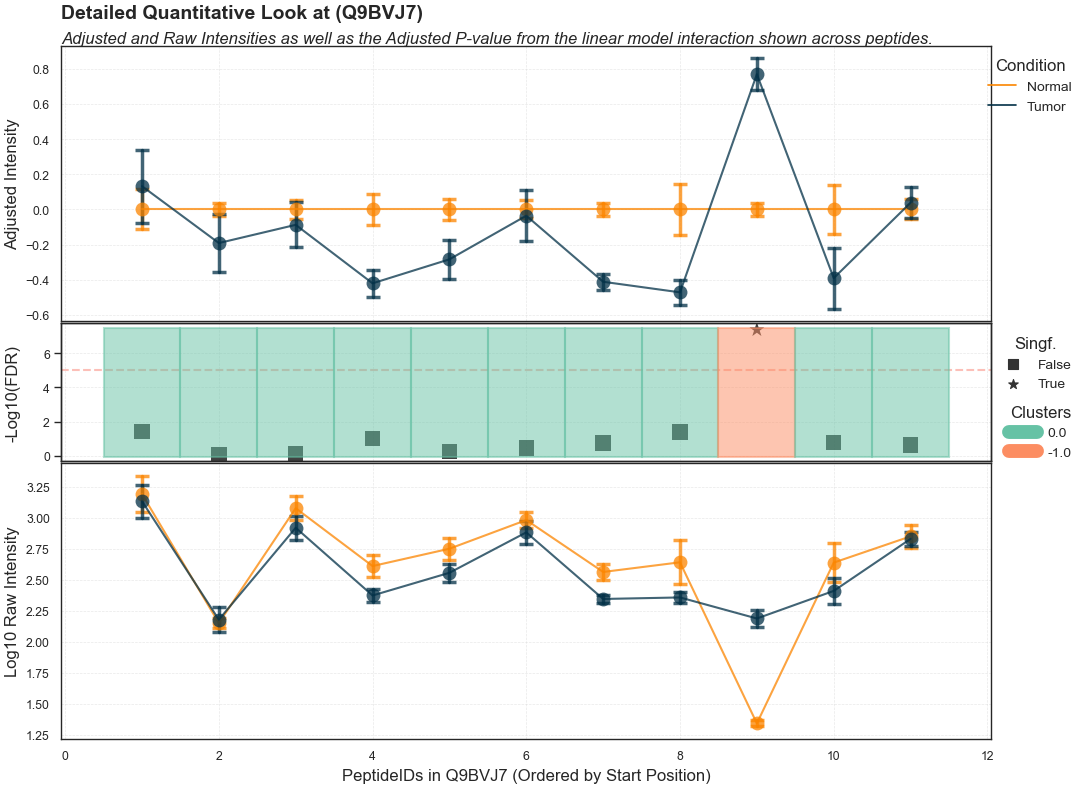

In [23]:
current_protein = 'Q9BVJ7'
to_save = False

print(f'Current Protein: {current_protein}')

## Detailed Peptide with Clusters
_ = plots.detailed_peptide_with_clusters(
    data=results_df,
    cur_protein=current_protein,
    pThr=pThr,
    condition_palette=status_colors,
    save=to_save,
    filename=f"PeptideIntensity_withClusters_{current_protein}",
    filepath=figure_path,
    fileformats=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

In [24]:
utils.view_table(
    expanded_info_data.loc[
        expanded_info_data["Protein"] == current_protein
    ],
    page_number=1
)

Total pages: 1, Current page: 1


,Protein,Peptide,proteinDescription,geneName,startpos,endpos,seqLength,trace,Cov%,isCAP,PeptideID,TumorRegulation,pval,adj.pvalue,isSignificant,ProteoformGroup,cluster_id
95260,Q9BVJ7,LAGLALPR,Dual specificity protein phosphatase 23,DUSP23,15,23,150,0,95.3333,False,1,Down,0.0119,0.0387,False,0.0000,5
95261,Q9BVJ7,LPAHYQFLLDLGVR,Dual specificity protein phosphatase 23,DUSP23,23,37,150,0,95.3333,False,2,Up,0.7985,0.8855,False,0.0000,8
95262,Q9BVJ7,HLVSLTER,Dual specificity protein phosphatase 23,DUSP23,37,45,150,0,95.3333,False,3,Down,0.5495,0.7101,False,0.0000,0
95263,Q9BVJ7,GPPHSDSCPGLTLHR,Dual specificity protein phosphatase 23,DUSP23,45,60,150,0,95.3333,False,4,Down,0.0375,0.0997,False,0.0000,8
95264,Q9BVJ7,IPDFCPPAPDQIDR,Dual specificity protein phosphatase 23,DUSP23,62,76,150,0,95.3333,False,5,Down,0.3722,0.5528,False,0.0000,4
95265,Q9BVJ7,FVQIVDEANAR,Dual specificity protein phosphatase 23,DUSP23,76,87,150,0,95.3333,False,6,Down,0.1882,0.3436,False,0.0000,5
95266,Q9BVJ7,GEAVGVHCALGFGR,Dual specificity protein phosphatase 23,DUSP23,87,101,150,0,95.3333,False,7,Down,0.0788,0.1792,False,0.0000,4
95267,Q9BVJ7,GLAAGDAIAEIRR,Dual specificity protein phosphatase 23,DUSP23,114,127,150,0,95.3333,False,8,Down,0.0123,0.0397,False,0.0000,0
95268,Q9BVJ7,RLRPGSIETYEQEK,Dual specificity protein phosphatase 23,DUSP23,126,140,150,1,95.3333,False,9,Up,0.0000,0.0000,True,-1.0000,7
95269,Q9BVJ7,LRPGSIETYEQEK,Dual specificity protein phosphatase 23,DUSP23,127,140,150,0,95.3333,False,10,Down,0.0692,0.1619,False,0.0000,0


In [25]:
final_res
utils.view_table(
    final_res.loc[
        final_res["Protein"] == current_protein
    ],
    page_number=1
)

Total pages: 1, Current page: 1


,feature,startpos,endpos,note,Protein
1588,VARIANT,131.0000,131.0000,G -> S (in dbSNP:rs1129923),Q9BVJ7
1589,CONFLICT,132.0000,132.0000,S -> P (in Ref. 2; BAA91172),Q9BVJ7


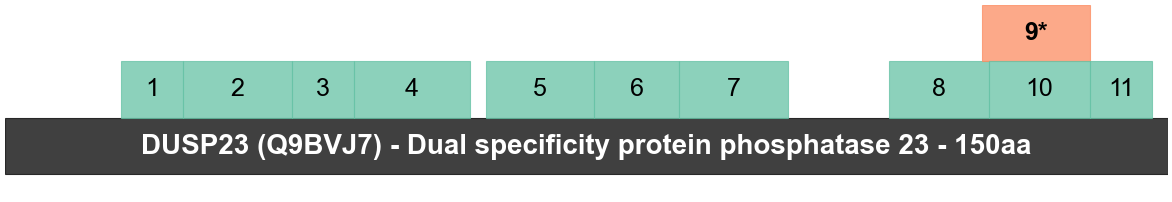

In [26]:
subset = expanded_info_data.loc[
    expanded_info_data["Protein"] == current_protein
] # Contains the peptides (startpos, endpos, trace(for place ontop)) protein seqLength
# Make dictionary for the peptide colors
cur_palette = dict(
    zip(
        subset['ProteoformGroup'].astype(int).unique(), 
        sns.color_palette("Set2", n_colors=subset['ProteoformGroup'].nunique()).as_hex()
    )
)
# Ensure -1 is included in the palette
if -1 not in cur_palette:
    cur_palette[-1] = sns.color_palette("Set2", n_colors=1).as_hex()[0]

cur_seqLength = subset['seqLength'].max()
cur_protein = subset['Protein'].unique()[0]
cur_description = subset['proteinDescription'].unique()[0]
cur_geneName = subset['geneName'].unique()[0]
cur_proteoformGroup = subset['ProteoformGroup'].unique()
protein_string = f"{cur_geneName} ({cur_protein}) - {cur_description} - {cur_seqLength}aa"

# Calculate the maximum number of traces to adjust the figure height
max_traces = subset['trace'].max()
fig_height = 2 + max_traces * 0.5

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, fig_height))
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.6 + max_traces * 0.25)

# First y item is the protein rectangle
ax.add_patch(plt.Rectangle((0, 0.1), 1, 0.25, color="black", alpha=0.75))
# Add the protein string centered horizontally and vertically
ax.text(0.5, 0.225, protein_string, ha='center', va='center', fontsize=20, fontweight='bold', color='white')

# Add the peptide rectangles
for i in subset.itertuples():
    st, en = i.startpos / i.seqLength, i.endpos / i.seqLength
    pid = i.PeptideID
    ptr = i.trace
    psg = i.isSignificant
    grp = i.ProteoformGroup
    if psg:
        pid = f"{pid}*"
        pfw = "bold"
    else:
        pfw = "normal"
    
    # Use traces to build rectangles on top if the peptides overlap
    if ptr > 0:
        ax.add_patch(plt.Rectangle((st, 0.35 + 0.25 * ptr), en - st, 0.25, color=cur_palette[grp], alpha=0.75))
    else:
        ax.add_patch(plt.Rectangle((st, 0.35), en - st, 0.25, color=cur_palette[grp], alpha=0.75))
        
    ax.text(st + 0.5 * (en - st), 0.475 + 0.25 * ptr, pid, ha='center', va='center', fontsize=18, fontweight=pfw, color='black')

# Remove the axis
ax.axis('off')

if to_save:
    # Save the figure
    plots.save_figures(
        plt.gcf(),
        filename=f"PeptidesOnProtein_{current_protein}",
        filepath=figure_path,
        fileformat=figure_formats,
        dpi=figure_dpi,
        transparent=transparet_bg
    )

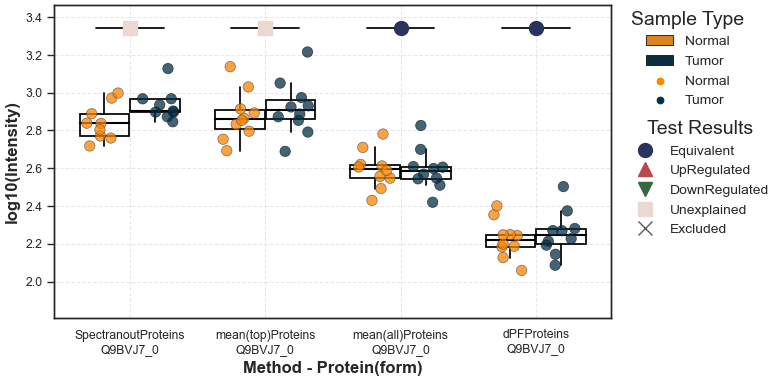

In [27]:
# Create UniqueNames:Group dictionary
sample_group = metadata.set_index("UniqueNames")['Group'].to_dict()
# Initialize the plot data
plot_data = pd.DataFrame()
# Loop through the centered data and create a plot data
for k, v in dataResults.items():
    if k != 'dPFProteins':
        tmp = v.loc[current_protein].to_frame().reset_index().rename(columns={current_protein: "Intensity"})
        tmp['Method'] = k
        tmp['Status'] = tmp['UniqueNames'].map(sample_group)
        tmp['Protein'] = current_protein + "_0"
        plot_data = pd.concat([plot_data, tmp], axis=0, ignore_index=True)
    else:
        uniq_pfgs = proteoform_info.loc[current_protein, 'Proteoform'].unique()
        for pfg in uniq_pfgs:
            tmp = v.loc[pfg].to_frame().reset_index().rename(columns={pfg: "Intensity", 'Sample': 'UniqueNames'})
            tmp['Method'] = k
            tmp['Status'] = tmp['UniqueNames'].map(sample_group)
            tmp['Protein'] = pfg
            plot_data = pd.concat([plot_data, tmp], axis=0, ignore_index=True)

plot_data['ID'] = plot_data['Method'] + "\n" + plot_data['Protein']
plot_data['log10(Intensity)'] = np.log10(plot_data['Intensity'])    

test_data = pd.DataFrame()
# Extract the test results for the current protein and pas
for k, v in testResults.items():
    if k != 'dPFProteins':
        try: 
            tmp = v.loc[
                v['Protein'] == current_protein, ['log2FC', 'log10(adj_pval)', 'Status']
            ].to_dict(orient='records')[0]
        except IndexError:
            tmp = {
                'log2FC': 0, 'log10(adj_pval)': 0, 'Status': 'Excluded'
            }
        # Update Status if Different to UpRegulated or DownRegulated
        if tmp['Status'] == 'Different':
            if tmp['log2FC'] > 0:
                tmp['Status'] = 'UpRegulated'
            else:
                tmp['Status'] = 'DownRegulated'

        tmp['Method'] = k
        tmp['Protein'] = current_protein + "_0"
        test_data = pd.concat([test_data, pd.DataFrame([tmp])], axis=0, ignore_index=True)

    else:
        for j in proteoform_info.loc[current_protein, 'Proteoform'].unique():
            try:
                tmp = v.loc[
                    v['Proteoform'] == j, ['log2FC', 'log10(adj_pval)', 'Status']
                ].to_dict(orient='records')[0]
            except IndexError:
                tmp = {
                    'log2FC': 0, 'log10(adj_pval)': 0, 'Status': 'Excluded'
                }
            # Update Status if Different to UpRegulated or DownRegulated
            if tmp['Status'] == 'Different':
                if tmp['log2FC'] > 0:
                    tmp['Status'] = 'UpRegulated'
                else:
                    tmp['Status'] = 'DownRegulated'

            tmp['Method'] = k
            tmp['Protein'] = current_protein + "_0"
            test_data = pd.concat([test_data, pd.DataFrame([tmp])], axis=0, ignore_index=True)

test_data['ID'] = test_data['Method'] + "\n" + test_data['Protein']
test_data
        

# Ensure the order is [SpectranoutProteins, mean(top)Proteins, mean(all)Proteins, dPFProteins-and-isoforms]
plot_data['Method'] = pd.Categorical(
    plot_data['Method'], 
    categories=['SpectranoutProteins', 'mean(top)Proteins', 'mean(all)Proteins', 'dPFProteins'],
    ordered=True
)
test_data['Method'] = pd.Categorical(
    test_data['Method'], 
    categories=['SpectranoutProteins', 'mean(top)Proteins', 'mean(all)Proteins', 'dPFProteins'],
    ordered=True
)

plot_data = plot_data.sort_values(["Method", 'ID'])
test_data = test_data.sort_values(["Method", 'ID'])

yOffset = 0.25
ymin = plot_data['log10(Intensity)'].min() - yOffset
ymax = plot_data['log10(Intensity)'].max() + yOffset

fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(
    ax=ax, data=plot_data,
    x='ID', y='log10(Intensity)', 
    hue='Status', palette=status_colors,
    width=.75, fliersize=0, linewidth=1.25,
    whiskerprops=dict(color="black"),
    capprops={"color": "black", "linewidth": 0},
    medianprops={"color": "black", "linewidth": 1.5},
    boxprops=dict(facecolor="none", edgecolor="black"),
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"},
)
stripplot = sns.stripplot(
    ax=ax, data=plot_data,
    x='ID', y='log10(Intensity)', 
    hue='Status', palette=status_colors, 
    dodge=True, linewidth=0.5,
    jitter=0.25, s=7.5, alpha=0.75,
    rasterized=True
)

# Adds annotation for the test results
for i, cur_data in test_data.iterrows():
    if cur_data['ID'] in plot_data['ID'].unique().tolist():
        x = plot_data['ID'].unique().tolist().index(cur_data['ID'])
        y = plot_data['log10(Intensity)'].max() + (yOffset * 0.5)
        # Draw lines to indicate the groups being compared
        ax.plot([x-0.25, x+0.25], [y, y], color="black", linewidth=1.25)
        # Annotate the p-value with a marker
        ax.plot(x, y, marker=test_markers[cur_data['Status']], color=test_colors[cur_data['Status']], markersize=10)

ax.set_ylim(ymin, ymax)
ax.set_ylabel("log10(Intensity)", fontsize=12, fontweight="bold")
ax.set_xlabel("Method - Protein(form)", fontsize=12, fontweight="bold")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
ax.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0., fontsize=10, frameon=False, title="Sample Type" ,title_fontsize=14, )
# Add another legend for the Test Results
ax2 = ax.twinx()
ax2.set_yticks([])
ax2.legend(
    handles=[
        plt.Line2D([0], [0], marker=test_markers[i], color=test_colors[i], markersize=10, linestyle="None", label=i)
        for i in test_colors.keys()
    ],
    title="Test Results",title_fontsize=14, 
    loc=2, fontsize=10, frameon=False,
    bbox_to_anchor=(1.025, .65), borderaxespad=0.
)

plt.tight_layout()

if to_save:
    # Save the figure
    plots.save_figures(
        plt.gcf(),
        filename=f"ProteinIntensity_Comparison_{current_protein}",
        filepath=figure_path,
        fileformat=figure_formats,
        dpi=figure_dpi,
        transparent=transparet_bg
    )

## Multi Peptide dPFs

### Proteins with dPFs and a PTM

#### Candidates:

- **MDK** (P21741):
    - This protein has an isoform that is found in cancer tissues with expression in the tumor bodies and surrounding normal cells. (26-81 Missing) Very interesting case to explore.\
- **RHOA** (P61586):
    - Example of crosslink and missed cleavages in the protein, it is used in the GTPase activity and the next section.
- **CRKL** (P46109):
    - Example of an neo N-termini that is not an isoform but in TopFIND. 
- **PTEN** (P60484):
    - Example of a protein with minimal number of peptides and two has mutagens that might be the reason in down in normal
- **GATA2** (P23769):
    - Example of a protein with modifed residues in all the peptides in the cluster.
- **XIAP** (P98170):
    - Example of a protein with two additional forms, one with lower in Tumor and one in higer in Tumor. There are a lot of annotations mutagens, variants, and PTMs.
- **FLCN** (Q8NFG4):
    - Many isoforms and clear drop in middle, can be supplementary highlight.


In [28]:
dpf_with_tpm = protein_info[
    (protein_info['Cov%'] > 50) &
    (protein_info['N(dPFs)'] == 1) &
    (protein_info['N(PTM)']  == 0) #& 
    # (protein_info['isCAP'] == 1)
    
].sort_values("Cov%", ascending=False)

print(f"The number of proteins with single PTMs (and UniProt Annotation Match) and no dPFs: {dpf_with_tpm.shape[0]}")
utils.view_table(
    dpf_with_tpm, 
    page_size=10, 
    page_number=6
)

The number of proteins with single PTMs (and UniProt Annotation Match) and no dPFs: 1073
Total pages: 108, Current page: 6


,Protein,isCAP,geneName,Cov%,seqLength,Peptide,isSignificant,hasIsoforms,Significant%,N(canonical),N(dPFs),N(PTM)
3228,Q12904,False,AIMP1,86.2179,312,15,2,True,13.3333,1,1,0
1981,Q8WW12,False,PCNP,85.9551,178,12,2,True,16.6667,1,1,0
6007,P16152,False,CBR1,85.9206,277,18,1,True,5.5556,1,1,0
5298,P62258,False,YWHAE,85.8824,255,26,2,True,7.6923,1,1,0
3646,Q15181,False,PPA1,85.8131,289,16,2,False,12.5000,1,1,0
3790,P00491,False,PNP,85.8131,289,17,2,False,11.7647,1,1,0
4583,Q04837,False,SSBP1,85.8108,148,10,1,False,10.0000,1,1,0
5949,P35998,False,PSMC2,85.6813,433,34,2,True,5.8824,1,1,0
6206,Q99623,False,PHB2,85.6187,299,22,1,True,4.5455,1,1,0
5500,P52943,False,CRIP2,85.5769,208,14,1,True,7.1429,1,1,0


Current Protein: P00491


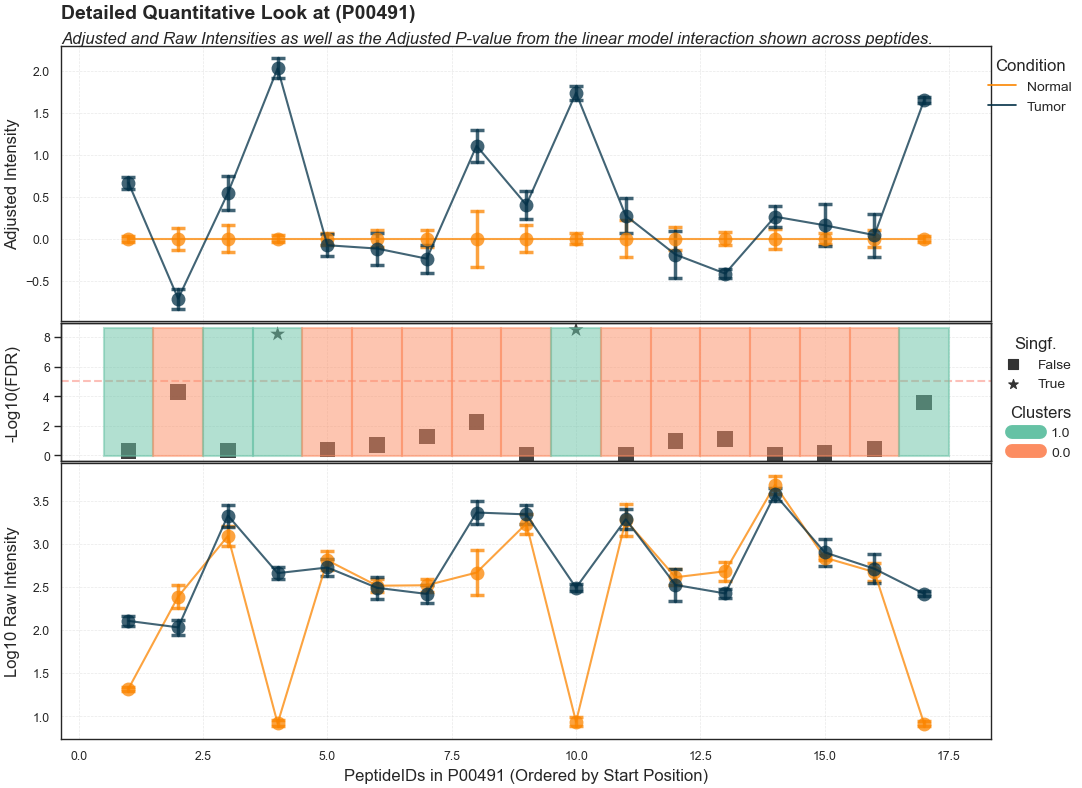

In [29]:
current_protein = 'P00491'
to_save = False

print(f'Current Protein: {current_protein}')

## Detailed Peptide with Clusters
_ = plots.detailed_peptide_with_clusters(
    data=results_df,
    cur_protein=current_protein,
    pThr=pThr,
    condition_palette=status_colors,
    save=to_save,
    filename=f"PeptideIntensity_withClusters_{current_protein}",
    filepath=figure_path,
    fileformats=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

In [30]:
utils.view_table(
    expanded_info_data.loc[
        expanded_info_data["Protein"] == current_protein
    ],
    page_number=1
)

Total pages: 1, Current page: 1


,Protein,Peptide,proteinDescription,geneName,startpos,endpos,seqLength,trace,Cov%,isCAP,PeptideID,TumorRegulation,pval,adj.pvalue,isSignificant,ProteoformGroup,cluster_id
14381,P00491,NTAEWLLSHTK,Purine nucleoside phosphorylase,PNP,11,22,289,0,85.8131,False,1,Up,0.3313,0.5116,False,1.0000,7
14382,P00491,HRPQVAIICGSGLGGLTDK,Purine nucleoside phosphorylase,PNP,22,41,289,0,85.8131,False,2,Down,0.0000,0.0001,False,0.0000,0
14383,P00491,LTQAQIFDYGEIPNFPR,Purine nucleoside phosphorylase,PNP,41,58,289,0,85.8131,False,3,Up,0.2942,0.4718,False,1.0000,7
14384,P00491,LVFGFLNGR,Purine nucleoside phosphorylase,PNP,67,76,289,0,85.8131,False,4,Up,0.0000,0.0000,True,1.0000,7
14385,P00491,ACVMMQGR,Purine nucleoside phosphorylase,PNP,76,84,289,0,85.8131,False,5,Down,0.2206,0.3851,False,0.0000,0
14386,P00491,FHMYEGYPLWK,Purine nucleoside phosphorylase,PNP,84,95,289,0,85.8131,False,6,Down,0.0907,0.1996,False,0.0000,0
14387,P00491,VFHLLGVDTLVVTNAAGGLNPK,Purine nucleoside phosphorylase,PNP,101,123,289,0,85.8131,False,7,Down,0.0173,0.0529,False,0.0000,0
14388,P00491,FEVGDIMLIR,Purine nucleoside phosphorylase,PNP,123,133,289,0,85.8131,False,8,Up,0.0013,0.0057,False,0.0000,8
14389,P00491,DHINLPGFSGQNPLR,Purine nucleoside phosphorylase,PNP,133,148,289,0,85.8131,False,9,Up,0.8347,0.9075,False,0.0000,8
14390,P00491,DHINLPGFSGQNPLRGPNDER,Purine nucleoside phosphorylase,PNP,133,154,289,2,85.8131,False,10,Up,0.0000,0.0000,True,1.0000,7


In [31]:
utils.view_table(
    uniprot_annotation.loc[
        uniprot_annotation['protein_id'] == current_protein
    ].sort_values(["start", "end"]),
    # page_size=10,
    page_number=2
)

Total pages: 3, Current page: 2


,protein_id,feature,isoform_id,start,end,note
77702,P00491,STRAND,,129.0000,137.0000,
77703,P00491,HELIX,,138.0000,141.0000,
77704,P00491,TURN,,153.0000,155.0000,
77705,P00491,TURN,,163.0000,166.0000,
77706,P00491,HELIX,,168.0000,179.0000,
77680,P00491,VARIANT,,174.0000,NaN,A -> P (in PNPD; dbSNP:rs104894454)
77707,P00491,TURN,,180.0000,182.0000,
77708,P00491,STRAND,,188.0000,194.0000,
77681,P00491,VARIANT,,192.0000,NaN,Y -> C (in PNPD; dbSNP:rs104894452)
77709,P00491,STRAND,,197.0000,199.0000,


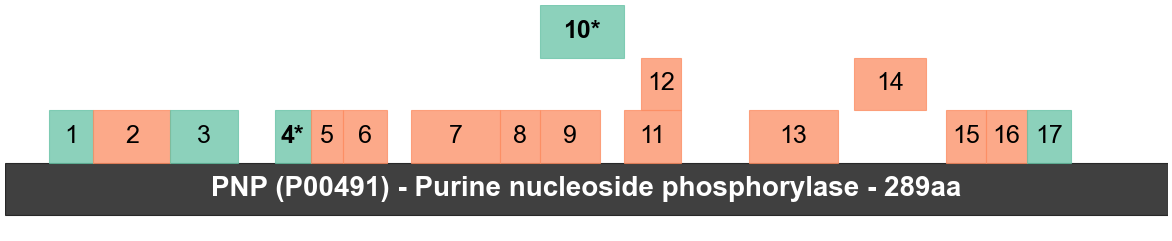

In [32]:
subset = expanded_info_data.loc[
    expanded_info_data["Protein"] == current_protein
] # Contains the peptides (startpos, endpos, trace(for place ontop)) protein seqLength
# Make dictionary for the peptide colors
cur_palette = dict(
    zip(
        subset['ProteoformGroup'].astype(int).unique(), 
        sns.color_palette("Set2", n_colors=subset['ProteoformGroup'].nunique()).as_hex()
    )
)
# Ensure -1 is included in the palette
if -1 not in cur_palette:
    cur_palette[-1] = sns.color_palette("Set2", n_colors=1).as_hex()[0]

cur_seqLength = subset['seqLength'].max()
cur_protein = subset['Protein'].unique()[0]
cur_description = subset['proteinDescription'].unique()[0]
cur_geneName = subset['geneName'].unique()[0]
cur_proteoformGroup = subset['ProteoformGroup'].unique()
protein_string = f"{cur_geneName} ({cur_protein}) - {cur_description} - {cur_seqLength}aa"

# Calculate the maximum number of traces to adjust the figure height
max_traces = subset['trace'].max()
fig_height = 2 + max_traces * 0.5

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, fig_height))
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.6 + max_traces * 0.25)

# First y item is the protein rectangle
ax.add_patch(plt.Rectangle((0, 0.1), 1, 0.25, color="black", alpha=0.75))
# Add the protein string centered horizontally and vertically
ax.text(0.5, 0.225, protein_string, ha='center', va='center', fontsize=20, fontweight='bold', color='white')

# Add the peptide rectangles
for i in subset.itertuples():
    st, en = i.startpos / i.seqLength, i.endpos / i.seqLength
    pid = i.PeptideID
    ptr = i.trace
    psg = i.isSignificant
    grp = i.ProteoformGroup
    if psg:
        pid = f"{pid}*"
        pfw = "bold"
    else:
        pfw = "normal"
    
    # Use traces to build rectangles on top if the peptides overlap
    if ptr > 0:
        ax.add_patch(plt.Rectangle((st, 0.35 + 0.25 * ptr), en - st, 0.25, color=cur_palette[grp], alpha=0.75))
    else:
        ax.add_patch(plt.Rectangle((st, 0.35), en - st, 0.25, color=cur_palette[grp], alpha=0.75))
        
    ax.text(st + 0.5 * (en - st), 0.475 + 0.25 * ptr, pid, ha='center', va='center', fontsize=18, fontweight=pfw, color='black')

# Remove the axis
ax.axis('off')

if to_save:
    # Save the figure
    plots.save_figures(
        plt.gcf(),
        filename=f"PeptidesOnProtein_{current_protein}",
        filepath=figure_path,
        fileformat=figure_formats,
        dpi=figure_dpi,
        transparent=transparet_bg
    )

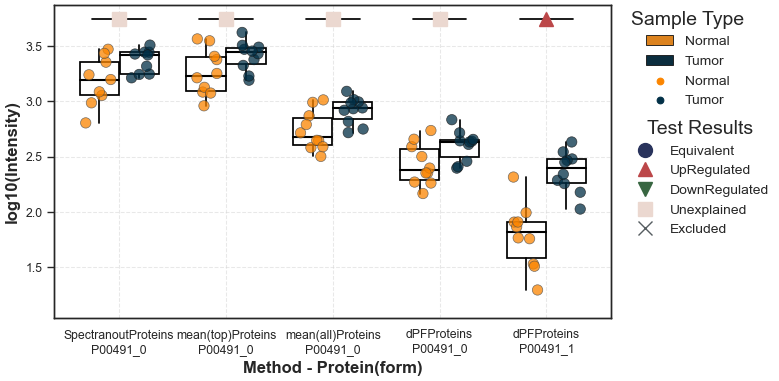

In [33]:
# Create UniqueNames:Group dictionary
sample_group = metadata.set_index("UniqueNames")['Group'].to_dict()
# Initialize the plot data
plot_data = pd.DataFrame()
# Loop through the centered data and create a plot data
for k, v in dataResults.items():
    if k != 'dPFProteins':
        tmp = v.loc[current_protein].to_frame().reset_index().rename(columns={current_protein: "Intensity"})
        tmp['Method'] = k
        tmp['Status'] = tmp['UniqueNames'].map(sample_group)
        tmp['Protein'] = current_protein + "_0"
        plot_data = pd.concat([plot_data, tmp], axis=0, ignore_index=True)
    else:
        uniq_pfgs = proteoform_info.loc[current_protein, 'Proteoform'].unique()
        for pfg in uniq_pfgs:
            tmp = v.loc[pfg].to_frame().reset_index().rename(columns={pfg: "Intensity", 'Sample': 'UniqueNames'})
            tmp['Method'] = k
            tmp['Status'] = tmp['UniqueNames'].map(sample_group)
            tmp['Protein'] = pfg
            plot_data = pd.concat([plot_data, tmp], axis=0, ignore_index=True)

plot_data['ID'] = plot_data['Method'] + "\n" + plot_data['Protein']
plot_data['log10(Intensity)'] = np.log10(plot_data['Intensity'])    

test_data = pd.DataFrame()
# Extract the test results for the current protein and pas
for k, v in testResults.items():
    if k != 'dPFProteins':
        try: 
            tmp = v.loc[
                v['Protein'] == current_protein, ['log2FC', 'log10(adj_pval)', 'Status']
            ].to_dict(orient='records')[0]
        except IndexError:
            tmp = {
                'log2FC': 0, 'log10(adj_pval)': 0, 'Status': 'Excluded'
            }
        # Update Status if Different to UpRegulated or DownRegulated
        if tmp['Status'] == 'Different':
            if tmp['log2FC'] > 0:
                tmp['Status'] = 'UpRegulated'
            else:
                tmp['Status'] = 'DownRegulated'

        tmp['Method'] = k
        tmp['Protein'] = current_protein + "_0"
        test_data = pd.concat([test_data, pd.DataFrame([tmp])], axis=0, ignore_index=True)

    else:
        for j in proteoform_info.loc[current_protein, 'Proteoform'].unique():
            try:
                tmp = v.loc[
                    v['Proteoform'] == j, ['log2FC', 'log10(adj_pval)', 'Status']
                ].to_dict(orient='records')[0]
            except IndexError:
                tmp = {
                    'log2FC': 0, 'log10(adj_pval)': 0, 'Status': 'Excluded'
                }
            # Update Status if Different to UpRegulated or DownRegulated
            if tmp['Status'] == 'Different':
                if tmp['log2FC'] > 0:
                    tmp['Status'] = 'UpRegulated'
                else:
                    tmp['Status'] = 'DownRegulated'

            tmp['Method'] = k
            tmp['Protein'] = j
            test_data = pd.concat([test_data, pd.DataFrame([tmp])], axis=0, ignore_index=True)

test_data['ID'] = test_data['Method'] + "\n" + test_data['Protein']
test_data
        

# Ensure the order is [SpectranoutProteins, mean(top)Proteins, mean(all)Proteins, dPFProteins-and-isoforms]
plot_data['Method'] = pd.Categorical(
    plot_data['Method'], 
    categories=['SpectranoutProteins', 'mean(top)Proteins', 'mean(all)Proteins', 'dPFProteins'],
    ordered=True
)
test_data['Method'] = pd.Categorical(
    test_data['Method'], 
    categories=['SpectranoutProteins', 'mean(top)Proteins', 'mean(all)Proteins', 'dPFProteins'],
    ordered=True
)

plot_data = plot_data.sort_values(["Method", 'ID'])
test_data = test_data.sort_values(["Method", 'ID'])

yOffset = 0.25
ymin = plot_data['log10(Intensity)'].min() - yOffset
ymax = plot_data['log10(Intensity)'].max() + yOffset

fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(
    ax=ax, data=plot_data,
    x='ID', y='log10(Intensity)', 
    hue='Status', palette=status_colors,
    width=.75, fliersize=0, linewidth=1.25,
    whiskerprops=dict(color="black"),
    capprops={"color": "black", "linewidth": 0},
    medianprops={"color": "black", "linewidth": 1.5},
    boxprops=dict(facecolor="none", edgecolor="black"),
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"},
)
stripplot = sns.stripplot(
    ax=ax, data=plot_data,
    x='ID', y='log10(Intensity)', 
    hue='Status', palette=status_colors, 
    dodge=True, linewidth=0.5,
    jitter=0.25, s=7.5, alpha=0.75,
    rasterized=True
)

# Adds annotation for the test results
for i, cur_data in test_data.iterrows():
    if cur_data['ID'] in plot_data['ID'].unique().tolist():
        x = plot_data['ID'].unique().tolist().index(cur_data['ID'])
        y = plot_data['log10(Intensity)'].max() + (yOffset * 0.5)
        # Draw lines to indicate the groups being compared
        ax.plot([x-0.25, x+0.25], [y, y], color="black", linewidth=1.25)
        # Annotate the p-value with a marker
        ax.plot(x, y, marker=test_markers[cur_data['Status']], color=test_colors[cur_data['Status']], markersize=10)

ax.set_ylim(ymin, ymax)
ax.set_ylabel("log10(Intensity)", fontsize=12, fontweight="bold")
ax.set_xlabel("Method - Protein(form)", fontsize=12, fontweight="bold")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
ax.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0., fontsize=10, frameon=False, title="Sample Type" ,title_fontsize=14, )
# Add another legend for the Test Results
ax2 = ax.twinx()
ax2.set_yticks([])
ax2.legend(
    handles=[
        plt.Line2D([0], [0], marker=test_markers[i], color=test_colors[i], markersize=10, linestyle="None", label=i)
        for i in test_colors.keys()
    ],
    title="Test Results",title_fontsize=14, 
    loc=2, fontsize=10, frameon=False,
    bbox_to_anchor=(1.025, .65), borderaxespad=0.
)

plt.tight_layout()

if to_save:
    # Save the figure
    plots.save_figures(
        plt.gcf(),
        filename=f"ProteinIntensity_Comparison_{current_protein}",
        filepath=figure_path,
        fileformat=figure_formats,
        dpi=figure_dpi,
        transparent=transparet_bg
    )

## Proteolytic Cleavages

In [34]:
expanded_info_data

,Protein,Peptide,proteinDescription,geneName,startpos,endpos,seqLength,trace,Cov%,isCAP,PeptideID,TumorRegulation,pval,adj.pvalue,isSignificant,ProteoformGroup,cluster_id
0,A0A024RBG1,MKFKPNQTR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,1,10,181,0,23.7569,False,1,Up,0.0034,0.0132,False,0.0000,3
1,A0A024RBG1,TYDREGFK,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,10,18,181,0,23.7569,False,2,Down,0.0000,0.0000,True,1.0000,0
2,A0A024RBG1,SEQEDEVLLVSSSR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,27,41,181,0,23.7569,False,3,Down,0.0124,0.0400,False,0.0000,6
3,A0A024RBG1,LLGIFEQNQDR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,79,90,181,0,23.7569,False,4,Down,0.1599,0.3053,False,1.0000,0
4,A0A024RBG1,LLGIFEQNQDRK,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,79,91,181,1,23.7569,False,5,Down,0.4427,0.6194,False,1.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117210,Q9Y6Y8,VANQIKEEEEK,EC23-interacting protein,SEC23IP,904,915,1000,0,39.9000,False,24,Down,0.5531,0.7130,False,0.0000,3
117211,Q9Y6Y8,VANQIKEEEEKQVVEAEK,EC23-interacting protein,SEC23IP,904,922,1000,1,39.9000,False,25,Down,0.0000,0.0000,True,1.0000,0
117212,Q9Y6Y8,VVESPDFSKDEDYLGK,EC23-interacting protein,SEC23IP,922,938,1000,0,39.9000,False,26,Down,0.9177,0.9562,False,0.0000,10
117213,Q9Y6Y8,IDYVLQEK,EC23-interacting protein,SEC23IP,947,955,1000,1,39.9000,False,27,Up,0.0000,0.0000,True,2.0000,6


In [35]:
check_data = expanded_info_data.loc[
    expanded_info_data['Protein'].isin(proteinsWithSignf), 
].set_index("Protein")
check_data.drop(columns=["proteinDescription", "Cov%", 'pval'], inplace=True)
candidate_proteins = []
for cur_protein in proteinsWithSignf: 
    candCheck = False
    # Subset for the current protein
    cur_data = check_data.loc[cur_protein]
    pfgs = cur_data['ProteoformGroup'].value_counts()
    # Remove -1 index if exists
    pfgs = pfgs.drop(-1, errors='ignore')
    # Check if ProteoformGroup has non -1 values with more than 1 peptides
    if not np.any(pfgs > 1):   
        continue
    # Check for each pfgs
    for p in pfgs.index:
        # The first occurrance of the pfg
        pfg_data = cur_data.loc[cur_data['ProteoformGroup'] == p]
        if pfg_data.shape[0] == 0 or pfg_data.shape[0] == 1:
            continue
        # if the first is not isSignificant
        if not pfg_data['isSignificant'].any():
            continue
        # Check if the Tumor Regulation is same
        if pfg_data['TumorRegulation'].nunique() > 1:
            continue
        # Check if the PeptideIDs have no gaps
        if not np.all(np.diff(pfg_data['PeptideID']) == 1):
            continue
        # Get the unique tumor regulation
        tumorReg = pfg_data['TumorRegulation'].unique()[0]
        # Check if the tumor regulation is not the same as other groups
        if cur_data.loc[cur_data['ProteoformGroup'] != p, 'TumorRegulation'].nunique() > 1:
            continue

        # If everything is fine, add the protein to the candidate list
        candCheck = True

    if not candCheck:
        continue
    # Add the protein to the candidate list
    candidate_proteins.append(cur_protein)

#### Candidates:

- **MYL1** (P05976):
    - Non-CAP with a switch in the middle, indicating heavily modified peptides.
- **NDUFAF2** (Q9Y3D6):
    - Non-CAP with a missi in middle without apperent reason maybe variant?
- **CCDC51** (Q9H6T3):
    - Isoform 2 with missing at the beginning in the tumor samples.
- **EPHA2** (P29317):
    - There is an isoform overlaps two other peptides but last two likely belong to  
- **ECEL1** (O95672):
    - Bad clustering but there is a clear drop in the middle, this is a very interesting case to explore. Also has no annotations, so likely a new discovery.
- **L3MBTL2** (Q9Y468):
    - Isoform Example, with normal only exists at the end while the tumor is present in all peptides.

In [99]:
dpf_with_tpm = protein_info[
    protein_info['Protein'].isin(candidate_proteins) &
    # (protein_info['Cov%'] > 50)
    # (protein_info['N(dPFs)'] == 1) &
    # (protein_info['N(PTM)']  == 0) #& 
    # # (protein_info['isCAP'] == 1)
    protein_info['hasIsoforms'] == 1
].sort_values("Cov%", ascending=False)

print(f"The number of proteins with single PTMs (and UniProt Annotation Match) and no dPFs: {len(candidate_proteins)}")
utils.view_table(
    dpf_with_tpm, 
    page_size=10, 
    page_number=12
)

The number of proteins with single PTMs (and UniProt Annotation Match) and no dPFs: 330
Total pages: 22, Current page: 12


,Protein,isCAP,geneName,Cov%,seqLength,Peptide,isSignificant,hasIsoforms,Significant%,N(canonical),N(dPFs),N(PTM)
10,Q96B23,False,ARK2N,24.0099,404,4,2,True,50.0000,0,2,0
9,Q6P1L5,False,FAM117B,23.9389,589,4,2,True,50.0000,0,1,1
1615,Q68DA7,False,FMN1,23.7491,1419,10,2,True,20.0000,1,2,0
4401,Q9Y2V7,False,COG6,23.7443,657,10,1,True,10.0000,1,1,0
752,Q9UJ83,False,HACL1,23.7024,578,4,1,True,25.0000,1,1,0
342,O75167,False,PHACTR2,23.5016,634,11,3,True,27.2727,1,2,0
2833,Q969R5,False,L3MBTL2,23.2624,705,7,1,True,14.2857,1,1,0
3895,Q7Z3E5,False,ARMC9,23.2274,818,9,1,True,11.1111,1,1,0
1534,Q86V88,False,MDP1,22.7273,176,5,1,True,20.0000,1,1,0
1829,Q93084,False,ATP2A3,22.3223,999,11,2,True,18.1818,1,2,0


Current Protein: Q7Z3E5


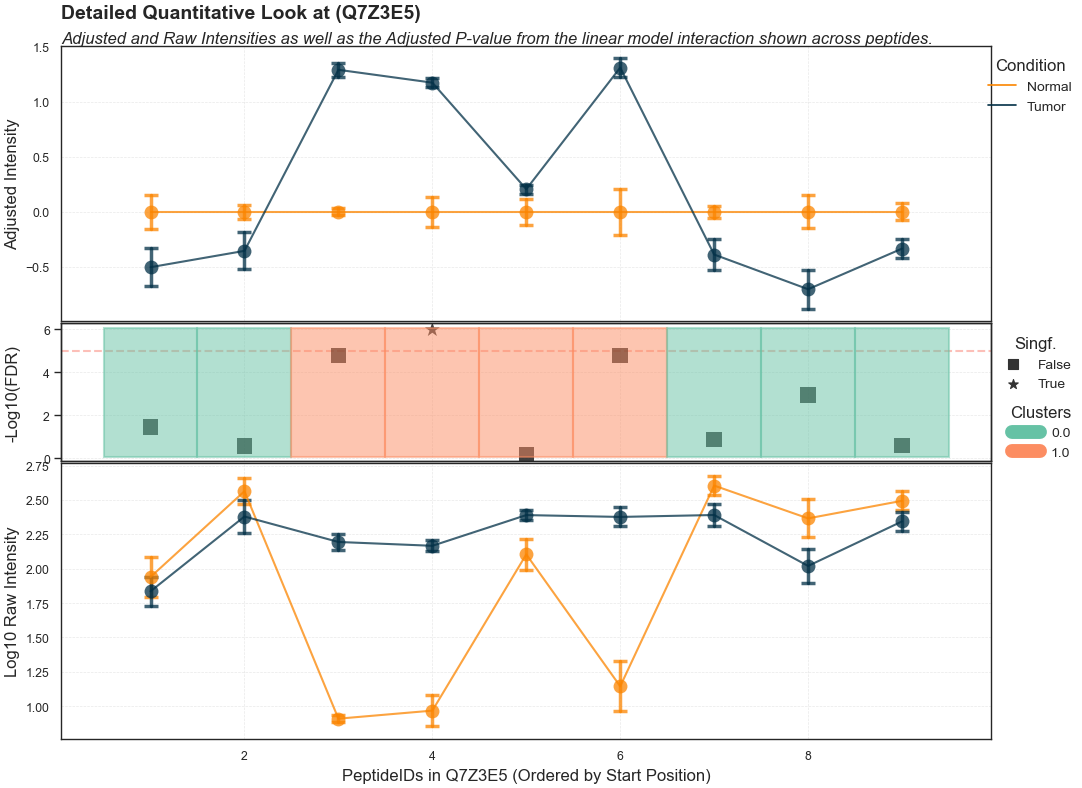

In [100]:
current_protein = 'Q7Z3E5'
to_save = False

print(f'Current Protein: {current_protein}')

## Detailed Peptide with Clusters
_ = plots.detailed_peptide_with_clusters(
    data=results_df,
    cur_protein=current_protein,
    pThr=pThr,
    condition_palette=status_colors,
    save=to_save,
    filename=f"PeptideIntensity_withClusters_{current_protein}",
    filepath=figure_path,
    fileformats=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

In [101]:
utils.view_table(
    expanded_info_data.loc[
        expanded_info_data["Protein"] == current_protein
    ],
    page_number=1
)

Total pages: 1, Current page: 1


,Protein,Peptide,proteinDescription,geneName,startpos,endpos,seqLength,trace,Cov%,isCAP,PeptideID,TumorRegulation,pval,adj.pvalue,isSignificant,ProteoformGroup,cluster_id
73748,Q7Z3E5,GDILAHESELLGLVK,LisH domain-containing protein ARMC9,ARMC9,1,16,818,0,23.2274,False,1,Down,0.0102,0.0339,False,0.0000,6
73749,Q7Z3E5,YSVGRPDKEELDEK,LisH domain-containing protein ARMC9,ARMC9,110,124,818,0,23.2274,False,2,Down,0.1287,0.2601,False,0.0000,6
73750,Q7Z3E5,ELFQDSWTPELK,LisH domain-containing protein ARMC9,ARMC9,164,176,818,0,23.2274,False,3,Up,0.0000,0.0000,False,1.0000,0
73751,Q7Z3E5,FLALISK,LisH domain-containing protein ARMC9,ARMC9,181,188,818,0,23.2274,False,4,Up,0.0000,0.0000,True,1.0000,0
73752,Q7Z3E5,LKDVPLLPSLDYEK,LisH domain-containing protein ARMC9,ARMC9,306,320,818,0,23.2274,False,5,Up,0.5170,0.6835,False,1.0000,0
73753,Q7Z3E5,DVPLLPSLDYEK,LisH domain-containing protein ARMC9,ARMC9,308,320,818,1,23.2274,False,6,Up,0.0000,0.0000,False,1.0000,0
73754,Q7Z3E5,AFLLQALR,LisH domain-containing protein ARMC9,ARMC9,333,341,818,0,23.2274,False,7,Down,0.0531,0.1313,False,0.0000,3
73755,Q7Z3E5,SVLQLLHSTSDVVR,LisH domain-containing protein ARMC9,ARMC9,374,388,818,0,23.2274,False,8,Down,0.0002,0.0011,False,0.0000,3
73756,Q7Z3E5,GRQEEPRPAPTGTPR,LisH domain-containing protein ARMC9,ARMC9,723,738,818,0,23.2274,False,9,Down,0.1189,0.2451,False,0.0000,3


In [102]:
utils.view_table(
    uniprot_annotation.loc[
        uniprot_annotation['protein_id'] == current_protein
    ].sort_values(["start", "end"]),
    # page_size=10,
    page_number=1
)

Total pages: 1, Current page: 1


,protein_id,feature,isoform_id,start,end,note
391087,Q7Z3E5,CHAIN,,1.0000,818.0000,LisH domain-containing protein ARMC9
391088,Q7Z3E5,DOMAIN,,7.0000,39.0000,LisH
391095,Q7Z3E5,VARIANT,,69.0000,NaN,G -> R (in JBTS30; uncertain significance; dbS...
391096,Q7Z3E5,VARIANT,,87.0000,NaN,Missing (in JBTS30; uncertain significance)
391097,Q7Z3E5,VARIANT,,108.0000,NaN,L -> F (in dbSNP:rs11558175)
391098,Q7Z3E5,VARIANT,,180.0000,NaN,I -> V (in dbSNP:rs1626450)
391106,Q7Z3E5,CONFLICT,,180.0000,NaN,"I -> E (in Ref. 1; AAX22760, 2; AAO63554, 3; C..."
391091,Q7Z3E5,COILED,,204.0000,230.0000,
391099,Q7Z3E5,VARIANT,,209.0000,NaN,I -> T (in dbSNP:rs16827883)
391100,Q7Z3E5,VARIANT,,222.0000,NaN,R -> H (in dbSNP:rs3752780)


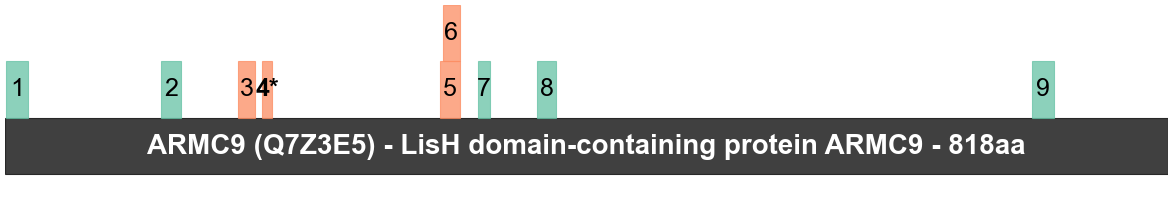

In [103]:
subset = expanded_info_data.loc[
    expanded_info_data["Protein"] == current_protein
] # Contains the peptides (startpos, endpos, trace(for place ontop)) protein seqLength
# Make dictionary for the peptide colors
cur_palette = dict(
    zip(
        subset['ProteoformGroup'].astype(int).unique(), 
        sns.color_palette("Set2", n_colors=subset['ProteoformGroup'].nunique()).as_hex()
    )
)
# Ensure -1 is included in the palette
if -1 not in cur_palette:
    cur_palette[-1] = sns.color_palette("Set2", n_colors=1).as_hex()[0]

cur_seqLength = subset['seqLength'].max()
cur_protein = subset['Protein'].unique()[0]
cur_description = subset['proteinDescription'].unique()[0]
cur_geneName = subset['geneName'].unique()[0]
cur_proteoformGroup = subset['ProteoformGroup'].unique()
protein_string = f"{cur_geneName} ({cur_protein}) - {cur_description} - {cur_seqLength}aa"

# Calculate the maximum number of traces to adjust the figure height
max_traces = subset['trace'].max()
fig_height = 2 + max_traces * 0.5

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, fig_height))
ax.set_xlim(0, 1)
ax.set_ylim(0, 0.6 + max_traces * 0.25)

# First y item is the protein rectangle
ax.add_patch(plt.Rectangle((0, 0.1), 1, 0.25, color="black", alpha=0.75))
# Add the protein string centered horizontally and vertically
ax.text(0.5, 0.225, protein_string, ha='center', va='center', fontsize=20, fontweight='bold', color='white')

# Add the peptide rectangles
for i in subset.itertuples():
    st, en = i.startpos / i.seqLength, i.endpos / i.seqLength
    pid = i.PeptideID
    ptr = i.trace
    psg = i.isSignificant
    grp = i.ProteoformGroup
    if psg:
        pid = f"{pid}*"
        pfw = "bold"
    else:
        pfw = "normal"
    
    # Use traces to build rectangles on top if the peptides overlap
    if ptr > 0:
        ax.add_patch(plt.Rectangle((st, 0.35 + 0.25 * ptr), en - st, 0.25, color=cur_palette[grp], alpha=0.75))
    else:
        ax.add_patch(plt.Rectangle((st, 0.35), en - st, 0.25, color=cur_palette[grp], alpha=0.75))
        
    ax.text(st + 0.5 * (en - st), 0.475 + 0.25 * ptr, pid, ha='center', va='center', fontsize=18, fontweight=pfw, color='black')

# Remove the axis
ax.axis('off')

if to_save:
    # Save the figure
    plots.save_figures(
        plt.gcf(),
        filename=f"PeptidesOnProtein_{current_protein}",
        filepath=figure_path,
        fileformat=figure_formats,
        dpi=figure_dpi,
        transparent=transparet_bg
    )

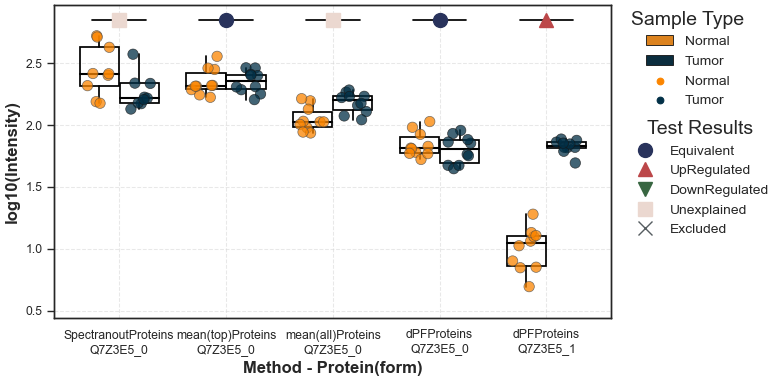

In [104]:
# Create UniqueNames:Group dictionary
sample_group = metadata.set_index("UniqueNames")['Group'].to_dict()
# Initialize the plot data
plot_data = pd.DataFrame()
# Loop through the centered data and create a plot data
for k, v in dataResults.items():
    if k != 'dPFProteins':
        tmp = v.loc[current_protein].to_frame().reset_index().rename(columns={current_protein: "Intensity"})
        tmp['Method'] = k
        tmp['Status'] = tmp['UniqueNames'].map(sample_group)
        tmp['Protein'] = current_protein + "_0"
        plot_data = pd.concat([plot_data, tmp], axis=0, ignore_index=True)
    else:
        uniq_pfgs = proteoform_info.loc[current_protein, 'Proteoform'].unique()
        for pfg in uniq_pfgs:
            tmp = v.loc[pfg].to_frame().reset_index().rename(columns={pfg: "Intensity", 'Sample': 'UniqueNames'})
            tmp['Method'] = k
            tmp['Status'] = tmp['UniqueNames'].map(sample_group)
            tmp['Protein'] = pfg
            plot_data = pd.concat([plot_data, tmp], axis=0, ignore_index=True)

plot_data['ID'] = plot_data['Method'] + "\n" + plot_data['Protein']
plot_data['log10(Intensity)'] = np.log10(plot_data['Intensity'])    

test_data = pd.DataFrame()
# Extract the test results for the current protein and pas
for k, v in testResults.items():
    if k != 'dPFProteins':
        try: 
            tmp = v.loc[
                v['Protein'] == current_protein, ['log2FC', 'log10(adj_pval)', 'Status']
            ].to_dict(orient='records')[0]
        except IndexError:
            tmp = {
                'log2FC': 0, 'log10(adj_pval)': 0, 'Status': 'Excluded'
            }
        # Update Status if Different to UpRegulated or DownRegulated
        if tmp['Status'] == 'Different':
            if tmp['log2FC'] > 0:
                tmp['Status'] = 'UpRegulated'
            else:
                tmp['Status'] = 'DownRegulated'

        tmp['Method'] = k
        tmp['Protein'] = current_protein + "_0"
        test_data = pd.concat([test_data, pd.DataFrame([tmp])], axis=0, ignore_index=True)

    else:
        for j in proteoform_info.loc[current_protein, 'Proteoform'].unique():
            try:
                tmp = v.loc[
                    v['Proteoform'] == j, ['log2FC', 'log10(adj_pval)', 'Status']
                ].to_dict(orient='records')[0]
            except IndexError:
                tmp = {
                    'log2FC': 0, 'log10(adj_pval)': 0, 'Status': 'Excluded'
                }
            # Update Status if Different to UpRegulated or DownRegulated
            if tmp['Status'] == 'Different':
                if tmp['log2FC'] > 0:
                    tmp['Status'] = 'UpRegulated'
                else:
                    tmp['Status'] = 'DownRegulated'

            tmp['Method'] = k
            tmp['Protein'] = j
            test_data = pd.concat([test_data, pd.DataFrame([tmp])], axis=0, ignore_index=True)

test_data['ID'] = test_data['Method'] + "\n" + test_data['Protein']
test_data
        

# Ensure the order is [SpectranoutProteins, mean(top)Proteins, mean(all)Proteins, dPFProteins-and-isoforms]
plot_data['Method'] = pd.Categorical(
    plot_data['Method'], 
    categories=['SpectranoutProteins', 'mean(top)Proteins', 'mean(all)Proteins', 'dPFProteins'],
    ordered=True
)
test_data['Method'] = pd.Categorical(
    test_data['Method'], 
    categories=['SpectranoutProteins', 'mean(top)Proteins', 'mean(all)Proteins', 'dPFProteins'],
    ordered=True
)

plot_data = plot_data.sort_values(["Method", 'ID'])
test_data = test_data.sort_values(["Method", 'ID'])

yOffset = 0.25
ymin = plot_data['log10(Intensity)'].min() - yOffset
ymax = plot_data['log10(Intensity)'].max() + yOffset

fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(
    ax=ax, data=plot_data,
    x='ID', y='log10(Intensity)', 
    hue='Status', palette=status_colors,
    width=.75, fliersize=0, linewidth=1.25,
    whiskerprops=dict(color="black"),
    capprops={"color": "black", "linewidth": 0},
    medianprops={"color": "black", "linewidth": 1.5},
    boxprops=dict(facecolor="none", edgecolor="black"),
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"},
)
stripplot = sns.stripplot(
    ax=ax, data=plot_data,
    x='ID', y='log10(Intensity)', 
    hue='Status', palette=status_colors, 
    dodge=True, linewidth=0.5,
    jitter=0.25, s=7.5, alpha=0.75,
    rasterized=True
)

# Adds annotation for the test results
for i, cur_data in test_data.iterrows():
    if cur_data['ID'] in plot_data['ID'].unique().tolist():
        x = plot_data['ID'].unique().tolist().index(cur_data['ID'])
        y = plot_data['log10(Intensity)'].max() + (yOffset * 0.5)
        # Draw lines to indicate the groups being compared
        ax.plot([x-0.25, x+0.25], [y, y], color="black", linewidth=1.25)
        # Annotate the p-value with a marker
        ax.plot(x, y, marker=test_markers[cur_data['Status']], color=test_colors[cur_data['Status']], markersize=10)

ax.set_ylim(ymin, ymax)
ax.set_ylabel("log10(Intensity)", fontsize=12, fontweight="bold")
ax.set_xlabel("Method - Protein(form)", fontsize=12, fontweight="bold")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
ax.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0., fontsize=10, frameon=False, title="Sample Type" ,title_fontsize=14, )
# Add another legend for the Test Results
ax2 = ax.twinx()
ax2.set_yticks([])
ax2.legend(
    handles=[
        plt.Line2D([0], [0], marker=test_markers[i], color=test_colors[i], markersize=10, linestyle="None", label=i)
        for i in test_colors.keys()
    ],
    title="Test Results",title_fontsize=14, 
    loc=2, fontsize=10, frameon=False,
    bbox_to_anchor=(1.025, .65), borderaxespad=0.
)

plt.tight_layout()

if to_save:
    # Save the figure
    plots.save_figures(
        plt.gcf(),
        filename=f"ProteinIntensity_Comparison_{current_protein}",
        filepath=figure_path,
        fileformat=figure_formats,
        dpi=figure_dpi,
        transparent=transparet_bg
    )